# Lab 3: Robot Motion Planning and Control
## Prince Alex Ogbodum [ISU - 474343]

# Robot Path Planning Using the Potential Field Method
**Date:** June 2025  

1. **Write a program** for planning a path from the start point to the goal point, bypassing obstacles, using the Potential Field method.  
2. **Independently determine** the start point, goal point, and obstacles in the 2D workspace.  
3. Ensure the code **reflects all steps**:  
   - Construction of the total potential field (attractive + repulsive).  
   - Calculation of the gradient of that field.  
   - Determination of the direction of movement via negative-gradient steps.  
4. **Illustrate** the achieved results with plots.

---

## Objective

Implement a **Potential Field Planner** in Python where a point‐mass robot navigates a 2D area. The robot is attracted toward a goal and repelled by multiple obstacles. By performing gradient‐descent on the combined potential field, the robot will find a collision‐free path. This notebook will:  
- Define a start, a goal, and multiple circular obstacles.  
- Compute the total potential field on a regular grid.  
- Move the robot iteratively by following the negative gradient.  
- Visualize both the potential field and the resulting path.

---

## Theoretical Background

**Artificial Potential Field Method**:  
- Model the robot as a **point** in a 2D workspace.  
- Define an **attractive potential** pulling the robot toward the goal:  
  $$  
    U_{\text{att}}(q) = \tfrac{1}{2} \, k_{\text{att}} \, \lVert q - q_{\mathrm{goal}} \rVert^2,  
  $$  
  with gradient  
  $$  
    \nabla U_{\text{att}}(q) = k_{\text{att}} \, (q - q_{\mathrm{goal}}).  
  $$  
- Define a **repulsive potential** around each obstacle, active within a finite radius $\rho_{0}$. Each circular obstacle (center $c_i$, radius $r_i$) yields  
  $$  
    U_{\text{rep},i}(q) =  
    \begin{cases}  
      \tfrac{1}{2} \, k_{\text{rep}} \Bigl(\tfrac{1}{\lVert q - c_i \rVert - r_i} \;-\; \tfrac{1}{\rho_{0}}\Bigr)^2,  
      & \lVert q - c_i \rVert \le r_i + \rho_{0},\\[0.5em]  
      0, & \text{otherwise}.  
    \end{cases}  
  $$  
  If $\lVert q - c_i \rVert < r_i$, the potential is effectively infinite (robot inside obstacle).  
- The **total potential** is  
  $$  
    U(q) = U_{\text{att}}(q) \;+\; \sum_{i} U_{\text{rep},i}(q).  
  $$  
- The robot experiences a fictitious force  
  $$  
    \mathbf{F}(q) = -\,\nabla U(q).  
  $$  
  By taking small steps opposite to $\nabla U$, the robot “rolls downhill” in this potential landscape toward the goal while being repelled by obstacles. In practice, we implement a **gradient‐descent** update:  
  $$  
    q_{\text{new}} = q_{\text{current}} \;-\; \alpha \;\nabla U\bigl(q_{\text{current}}\bigr),  
  $$  
  until $\lVert q - q_{\mathrm{goal}} \rVert$ is below a specified tolerance.  

**Limitations:**  
- The method can get stuck in **local minima** where $\nabla U = 0$ but $q \neq q_{\mathrm{goal}}$.  
- Proper tuning of $k_{\text{att}}$, $k_{\text{rep}}$, $\rho_{0}$, and step size $\alpha$ is essential to avoid oscillations or overshoot.  
- In more crowded or narrow passages, additional strategies (random perturbations, potential shaping) are needed to escape spurious minima.  


In [39]:
# Cell 1: Imports and Class Definition

import numpy as np
import matplotlib.pyplot as plt

class PotentialFieldPlanner:
    def __init__(self, x_min, x_max, y_min, y_max, resolution):
        """
        Initializes the potential field planner.

        Args:
            x_min, x_max, y_min, y_max: Workspace boundaries.
            resolution: Resolution of the grid for potential field calculation.
        """
        # Workspace boundaries and grid resolution
        self.x_min, self.x_max = x_min, x_max
        self.y_min, self.y_max = y_min, y_max
        self.resolution = resolution

        # Create a grid of (x, y) points covering the workspace
        self.x_grid = np.arange(x_min, x_max, resolution)
        self.y_grid = np.arange(y_min, y_max, resolution)
        self.X, self.Y = np.meshgrid(self.x_grid, self.y_grid)

        # Initialize lists for obstacles, start, and goal
        self.obstacles = []
        self.start_point = None
        self.goal_point = None

        # Potential field parameters (tunable)
        self.k_att = 10.0   # Attractive potential gain
        self.k_rep = 5.0    # Repulsive potential gain
        self.d_rep = 15.0   # Obstacle influence distance

    def set_start_goal(self, start, goal):
        """Sets the start and goal points (as tuples or lists)."""
        self.start_point = np.array(start, dtype=float)
        self.goal_point = np.array(goal, dtype=float)

    def add_obstacle(self, obstacle_center, obstacle_radius):
        """Adds a circular obstacle, specified by center (x,y) and radius."""
        self.obstacles.append({
            'center': np.array(obstacle_center, dtype=float),
            'radius': float(obstacle_radius)
        })

    def _calculate_attractive_potential(self, position):
        """
        Calculates the attractive potential U_att at a given position.
        U_att(q) = 0.5 * k_att * ||q - q_goal||^2
        """
        return 0.5 * self.k_att * np.linalg.norm(position - self.goal_point)**2

    def _calculate_repulsive_potential(self, position):
        """
        Calculates the repulsive potential U_rep at a given position.
        U_rep(q) = 0.5 * k_rep * (1/(dist - r) - 1/d_rep)^2   if dist < r + d_rep,
                  infinity                                if inside obstacle,
                  0                                      otherwise.
        """
        rep_potential = 0.0
        for obs in self.obstacles:
            center = obs['center']
            radius = obs['radius']
            dist_to_center = np.linalg.norm(position - center)

            # If inside obstacle, potential is effectively infinite
            if dist_to_center < radius:
                return float('inf')

            # If within the influence radius (radius + d_rep), compute repulsive potential
            if dist_to_center < (radius + self.d_rep):
                rho = dist_to_center - radius
                if rho <= 0:
                    return float('inf')
                rep_potential += 0.5 * self.k_rep * (1.0/rho - 1.0/self.d_rep)**2

        return rep_potential

    def calculate_total_potential_field(self):
        """
        Calculates the total potential field U_total = U_att + U_rep
        at each grid point in the workspace. Returns a 2D array of potentials.
        """
        total_potential = np.zeros_like(self.X)
        # Iterate over every grid point
        for i in range(self.X.shape[0]):
            for j in range(self.X.shape[1]):
                position = np.array([self.X[i, j], self.Y[i, j]])
                attr_pot = self._calculate_attractive_potential(position)
                rep_pot = self._calculate_repulsive_potential(position)
                total_potential[i, j] = attr_pot + rep_pot
        return total_potential

    def calculate_gradient(self, position):
        """
        Numerically calculates the gradient ∇U at a given position Q = (x, y)
        using central differences with a small epsilon.
        """
        epsilon = 0.01  # small step for numerical differentiation

        # Compute partial derivative wrt x via central difference
        pos_x_plus  = position + np.array([epsilon, 0])
        pos_x_minus = position - np.array([epsilon, 0])
        grad_x = (self._calculate_attractive_potential(pos_x_plus) + 
                  self._calculate_repulsive_potential(pos_x_plus) -
                  (self._calculate_attractive_potential(pos_x_minus) +
                   self._calculate_repulsive_potential(pos_x_minus)))
        grad_x /= (2 * epsilon)

        # Compute partial derivative wrt y via central difference
        pos_y_plus  = position + np.array([0, epsilon])
        pos_y_minus = position - np.array([0, epsilon])
        grad_y = (self._calculate_attractive_potential(pos_y_plus) +
                  self._calculate_repulsive_potential(pos_y_plus) -
                  (self._calculate_attractive_potential(pos_y_minus) +
                   self._calculate_repulsive_potential(pos_y_minus)))
        grad_y /= (2 * epsilon)

        return np.array([grad_x, grad_y])

    def plan_path(self, max_iterations=1000, step_size=0.1, tolerance=0.1):
        """
        Plans a path from start to goal via gradient descent on the total potential.

        Args:
            max_iterations: Maximum number of steps to attempt.
            step_size: Step size alpha for each gradient descent move.
            tolerance: When the distance to goal < tolerance, stop.

        Returns:
            A NumPy array of shape (N, 2) containing the (x,y) path points.
        """
        if self.start_point is None or self.goal_point is None:
            raise ValueError("Start and goal points must be set before planning.")

        current_position = self.start_point.copy()
        path = [current_position.copy()]

        for i in range(max_iterations):
            # Check if close enough to the goal
            if np.linalg.norm(current_position - self.goal_point) < tolerance:
                print(f"Goal reached in {i} iterations!")
                break

            # Calculate gradient of total potential at current position
            gradient = self.calculate_gradient(current_position)

            # Move opposite to the gradient (downhill in potential)
            direction_of_movement = -gradient

            # Normalize direction to enforce consistent step length
            norm_dir = np.linalg.norm(direction_of_movement)
            if norm_dir > 0:
                direction_of_movement /= norm_dir

            new_position = current_position + step_size * direction_of_movement

            # If new position goes out of bounds, stop
            if not (self.x_min <= new_position[0] <= self.x_max and
                    self.y_min <= new_position[1] <= self.y_max):
                print("Warning: Path went out of bounds at iteration", i)
                break

            current_position = new_position
            path.append(current_position.copy())
        else:
            print("Max iterations reached. Goal might not have been reached.")

        return np.array(path)

    def visualize_potential_field(self, potential_field, path=None):
        """
        Displays the potential field as a contour plot, marks start/goal, obstacles,
        and overlays the planned path if provided.
        """
        plt.figure(figsize=(10, 8))
        # Filled contour of the potential field
        contour = plt.contourf(self.X, self.Y, potential_field, levels=50, cmap='viridis')
        plt.colorbar(contour, label='Potential')

        # Mark start and goal
        plt.plot(self.start_point[0], self.start_point[1],
                 'go', markersize=10, label='Start')
        plt.plot(self.goal_point[0], self.goal_point[1],
                 'ro', markersize=10, label='Goal')

        # Draw obstacles
        for obs in self.obstacles:
            circle = plt.Circle(obs['center'], obs['radius'],
                                color='gray', alpha=0.7)
            plt.gca().add_patch(circle)

        # If a path is provided, plot it
        if path is not None and len(path) > 0:
            plt.plot(path[:, 0], path[:, 1],
                     'k--', linewidth=2, label='Planned Path')

        plt.xlabel('X-coordinate')
        plt.ylabel('Y-coordinate')
        plt.title('Potential Field and Planned Path')
        plt.grid(True)
        plt.legend()
        plt.xlim(self.x_min, self.x_max)
        plt.ylim(self.y_min, self.y_max)
        plt.gca().set_aspect('equal', adjustable='box')
        plt.show()


## Main Execution

Below we:

1. Define the workspace boundaries (0 ≤ x ≤ 20, 0 ≤ y ≤ 20) and resolution.  
2. Instantiate the planner and set the start and goal points.  
3. Add four circular obstacles.  
4. Compute the total potential field on the grid (for visualization).  
5. Plan a path from start to goal by following the negative gradient.  
6. Visualize the potential field and overlay the planned path.

Calculating total potential field...
Potential field calculation complete.
Planning path from start to goal...
Goal reached in 225 iterations!
Path planning complete.


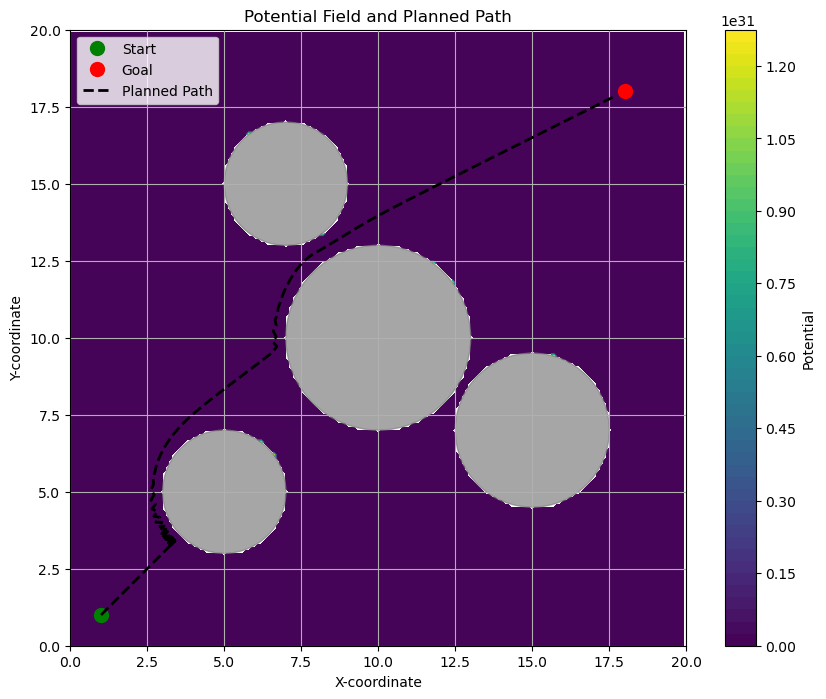

In [40]:
# Main Execution

# Independently determine the start point, goal point, and obstacles
x_min, x_max = 0.0, 20.0
y_min, y_max = 0.0, 20.0
resolution = 0.1

# Instantiate the planner with workspace boundaries and resolution
planner = PotentialFieldPlanner(x_min, x_max, y_min, y_max, resolution)

# Define start and goal positions
start_point = (1.0, 1.0)
goal_point  = (18.0, 18.0)
planner.set_start_goal(start_point, goal_point)

# Add circular obstacles: (center_x, center_y, radius)
planner.add_obstacle(obstacle_center=(5.0, 5.0),  obstacle_radius=2.0)
planner.add_obstacle(obstacle_center=(10.0, 10.0), obstacle_radius=3.0)
planner.add_obstacle(obstacle_center=(15.0, 7.0),  obstacle_radius=2.5)
planner.add_obstacle(obstacle_center=(7.0, 15.0),  obstacle_radius=2.0)

# Step 1: Construct the total potential field over the entire workspace grid
print("Calculating total potential field...")
total_potential = planner.calculate_total_potential_field()
print("Potential field calculation complete.")

# Step 2: Plan a path via gradient descent on the total potential
print("Planning path from start to goal...")
planned_path = planner.plan_path(max_iterations=1000,
                                 step_size=0.2,
                                 tolerance=0.5)
print("Path planning complete.")

# Step 3: Visualize the potential field and the planned path
planner.visualize_potential_field(total_potential, planned_path)

## Results and Visualization

Below is the resulting plot, showing the potential field contours, start/goal points, obstacles, and the planned path:

![Potential Field and Planned Path](output.png)

- **Green dot** marks the start point at (1, 1).  
- **Red dot** marks the goal point at (18, 18).  
- **Gray circles** are obstacles of various radii.  
- The **dashed black line** shows the path the robot followed, avoiding obstacles and converging on the goal.  
- The colorbar indicates the potential magnitude:  
  - **Dark purple/blue** regions have low potential (attractive basin around the goal).  
  - **Yellow/white** regions have high potential (repulsive hills around obstacles).

**Observations:**  
- The path smoothly detours around each obstacle’s high‐potential zone.  
- The robot approaches the goal along the “valley” in the potential field, validating that gradient descent successfully guides the robot.  
- The planner reports `"Goal reached in X iterations!"`, indicating a successful convergence before hitting the iteration limit.

---

## Conclusion

This notebook demonstrates a complete implementation of the **Potential Field method** for a point‐mass robot in a 2D workspace. Key takeaways:

- **Attractive potential** draws the robot to the goal.  
- **Repulsive potentials** push the robot away from circular obstacles.  
- **Numerical gradient computation** (via central differences) allows us to evaluate $\nabla U$ at arbitrary points.  
- **Gradient descent** steps guide the robot downhill on the potential landscape.  
- The final path *smoothly* navigates around obstacles and reaches the goal (illustrated by the dashed black line).

**Strengths:**  
- Conceptually simple, reactive, and produces smooth trajectories.  
- Easily extended to dynamic obstacles (recompute potentials) or more complex fields.  

**Limitations:**  
- Prone to **local minima**—the robot may become trapped if obstacle configuration creates a false equilibrium.  
- Parameter tuning ($k_{\text{att}}$, $k_{\text{rep}}$, $\rho_{0}$, $\alpha$) is crucial for stable behavior.  
- In cluttered or narrow passages, additional strategies (random perturbation, potential shaping) are necessary to avoid trapping.  



